Found 45 original images


/Users/alessandroarensberg/anaconda3/lib/python3.11/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/dr/j3tqf69d0slfbrmzqlmn4xx80000gn/T/ipykernel_45672/4198503128.py:69: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  transforms.append(A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.7))
/var/folders/dr/j3tqf69d0slfbrmzqlmn4xx80000gn/T/ipykernel_45672/4198503128.py:63: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  transforms.append(A.GaussNoise(var_limit=(10.0, 50.0), p=0.7))


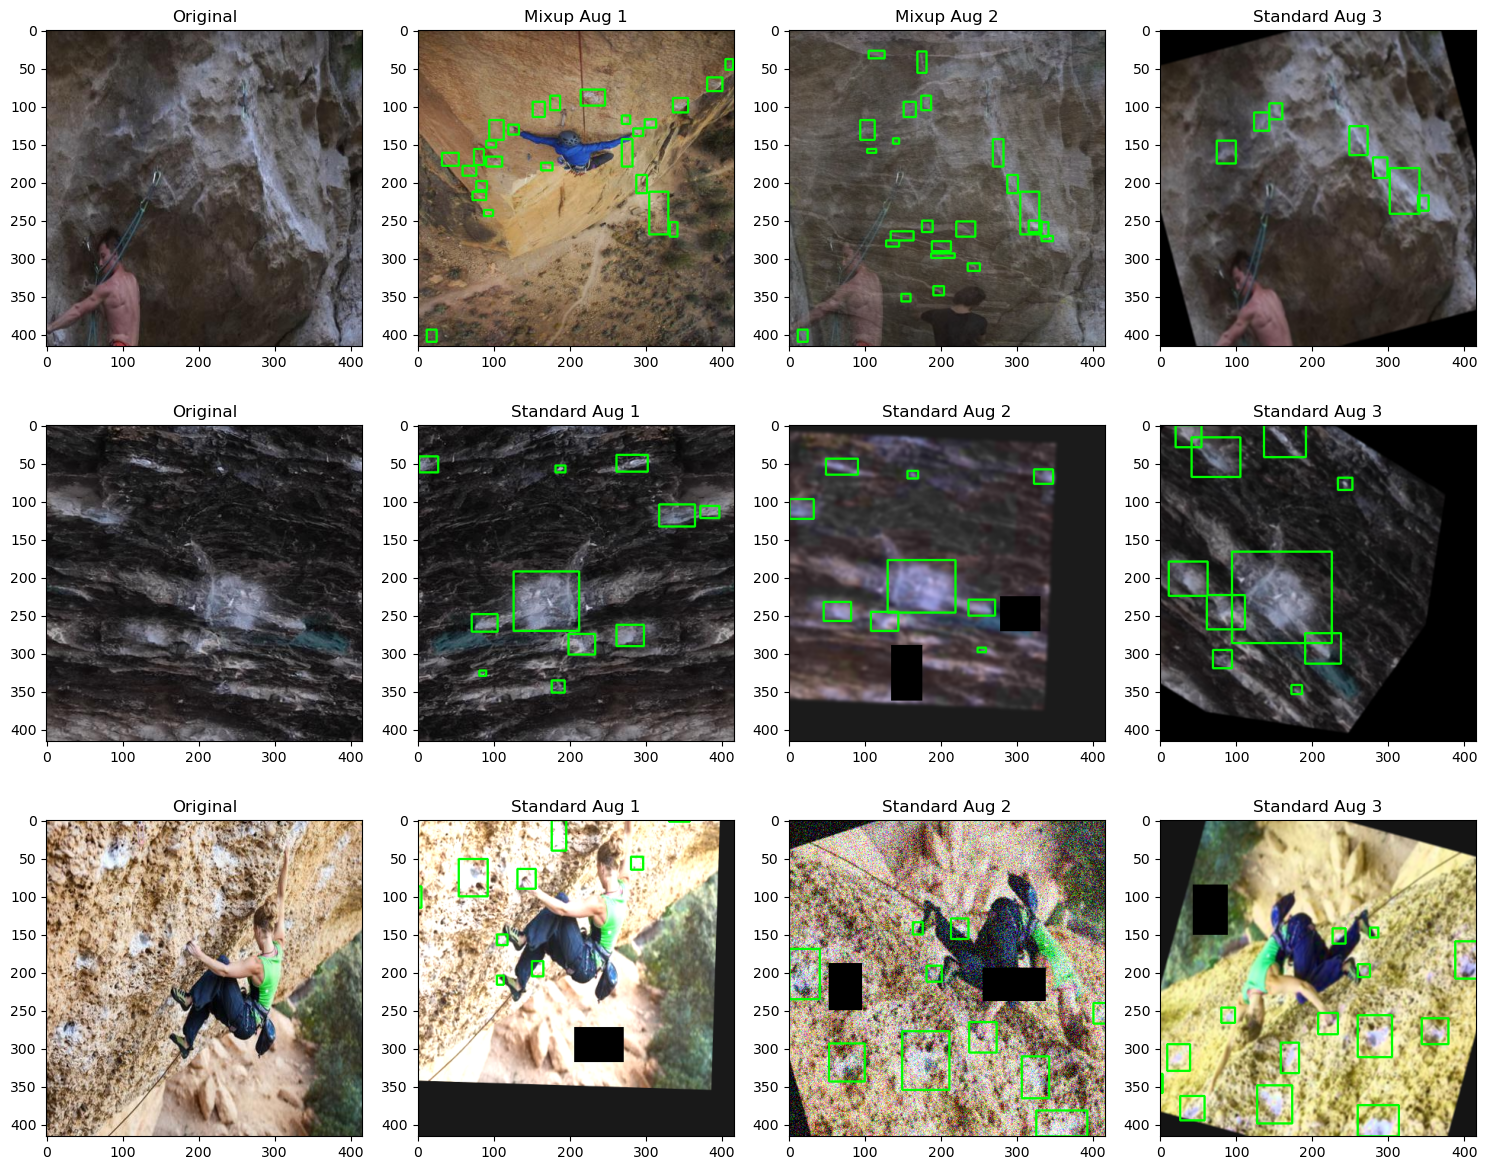

Processed 10/45 images, generated 220 augmentations
Processed 20/45 images, generated 440 augmentations
Processed 30/45 images, generated 660 augmentations
Processed 40/45 images, generated 880 augmentations
Processed 45/45 images, generated 990 augmentations
Augmentation complete! Generated 990 augmented images from 45 originals


In [ ]:
import os
import cv2
import random
from numpy import random as np_random
import albumentations as A
import matplotlib.pyplot as plt

# Input and output directories
PROJECT_PATH = os.getcwd().split('notebooks')[0]
INPUT_IMG_DIR = os.path.join(PROJECT_PATH, 'data', 'train', 'images')
INPUT_LBL_DIR = os.path.join(PROJECT_PATH, 'data', 'train', 'labels')
OUTPUT_IMG_DIR = os.path.join(PROJECT_PATH, 'data', 'augmented_train', 'images')
OUTPUT_LBL_DIR = os.path.join(PROJECT_PATH, 'data', 'augmented_train', 'labels')

# Create output directories
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LBL_DIR, exist_ok=True)

def read_yolo_annotations(path):
    bboxes = []
    class_ids = []
    with open(path, 'r') as f:
        for line in f:
            data = line.strip().split()
            if len(data) == 5:
                class_id, x_center, y_center, width, height = map(float, data)
                bboxes.append([x_center, y_center, width, height])
                class_ids.append(int(class_id))
    return bboxes, class_ids

def save_yolo_annotations(bboxes, class_ids, path):
    with open(path, 'w') as f:
        for i, bbox in enumerate(bboxes):
            x_center, y_center, width, height = [max(0, min(1, x)) for x in bbox]
            f.write(f'{class_ids[i]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n')

def get_augmentation(height, width):
    transforms = []
    
    # Select from different categories of transforms with varying probabilities
    
    # Geometric transforms
    if random.random() < 0.6:
        transforms.append(A.Rotate(limit=30, p=0.7))
    if random.random() < 0.5:
        transforms.append(A.HorizontalFlip(p=0.7))
    if random.random() < 0.3:  # Less likely for climbing scenes
        transforms.append(A.VerticalFlip(p=0.7))
    if random.random() < 0.5:
        transforms.append(A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.7))
    if random.random() < 0.3:
        transforms.append(A.Perspective(scale=(0.05, 0.1), p=0.7))
    
    # Color transforms
    if random.random() < 0.5:
        transforms.append(A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7))
    if random.random() < 0.5:
        transforms.append(A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=30, p=0.7))
    
    # Noise and blur
    if random.random() < 0.4:
        transforms.append(A.GaussNoise(var_limit=(10.0, 50.0), p=0.7))
    if random.random() < 0.4:
        transforms.append(A.GaussianBlur(blur_limit=3, p=0.7))
    
    # Random erasing (small rectangles)
    if random.random() < 0.4:
        transforms.append(A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.7))
    
    # Ensure we have at least one transform
    if not transforms:
        transforms.append(A.Rotate(limit=30, p=1.0))
    
    # Apply resize to original dimensions after all transforms
    transforms.append(A.Resize(height=height, width=width, p=1.0))
    
    return A.Compose(transforms, bbox_params=A.BboxParams(format='yolo', min_visibility=0.1, label_fields=['class_ids']))

def mixup(image1, bboxes1, class_ids1, image2, bboxes2, class_ids2, alpha=0.5):
    lam = np_random.beta(alpha, alpha)
    h1, w1 = image1.shape[:2]
    image2 = cv2.resize(image2, (w1, h1))
    mixed_image = cv2.addWeighted(image1, lam, image2, 1 - lam, 0)
    
    return mixed_image, bboxes1 + bboxes2, class_ids1 + class_ids2

def visualize_sample_augmentations(all_data, samples=3, augs_per_sample=3):
    if not all_data:
        print('No data available for visualization')
        return
    
    fig, axes = plt.subplots(samples, augs_per_sample + 1, figsize=(15, 4 * samples))
    
    for i in range(samples):
        idx = random.randint(0, len(all_data) - 1)
        img, bboxes, class_ids, img_file = all_data[idx]
        h, w = img.shape[:2]
        
        # Original image
        axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title('Original')
        
        # Draw bounding boxes
        for bbox, cls_id in zip(bboxes, class_ids):
            x_center, y_center, width, height = bbox
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            color = (0, 255, 0)
            cv2.rectangle(img.copy(), (x1, y1), (x2, y2), color, 2)
        
        # Generate augmentations
        for j in range(augs_per_sample):
            aug_type = random.choices(['standard', 'mixup'], weights=[0.8, 0.2], k=1)[0]
            
            if aug_type == 'standard':
                transform = get_augmentation(h, w)
                transformed = transform(image=img.copy(), bboxes=bboxes.copy(), class_ids=class_ids.copy())
                aug_img, aug_bboxes, aug_class_ids = transformed['image'], transformed['bboxes'], transformed['class_ids']
                title = f'Standard Aug {j+1}'
            else:
                other_idx = random.choice([k for k in range(len(all_data)) if k != idx])
                other_img, other_bboxes, other_class_ids, _ = all_data[other_idx]
                aug_img, aug_bboxes, aug_class_ids = mixup(
                    img.copy(), bboxes.copy(), class_ids.copy(), 
                    other_img.copy(), other_bboxes.copy(), other_class_ids.copy()
                )
                title = f'Mixup Aug {j+1}'
            
            # Display augmented image
            axes[i, j+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
            axes[i, j+1].set_title(title)
            
            # Draw bounding boxes on augmented image
            img_with_boxes = aug_img.copy()
            for bbox, cls_id in zip(aug_bboxes, aug_class_ids):
                x_center, y_center, width, height = bbox
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)
                color = (0, 255, 0)
                cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
                
            axes[i, j+1].imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
            
    plt.tight_layout()
    plt.show()

def process_images():
    image_files = [f for f in os.listdir(INPUT_IMG_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
    total_original = len(image_files)
    total_augmented = 0
    
    print(f'Found {total_original} original images')
    
    # Load all images and annotations
    all_data = []
    for img_file in image_files:
        img_path = os.path.join(INPUT_IMG_DIR, img_file)
        lbl_path = os.path.join(INPUT_LBL_DIR, os.path.splitext(img_file)[0] + '.txt')
        
        if not os.path.exists(lbl_path):
            print(f'No annotation found for {img_file}')
            continue
            
        img = cv2.imread(img_path)
        if img is None:
            print(f'Failed to read {img_file}')
            continue
            
        bboxes, class_ids = read_yolo_annotations(lbl_path)
        all_data.append((img, bboxes, class_ids, img_file))
    
    # Visualize sample augmentations before processing
    visualize_sample_augmentations(all_data)
    
    for idx, (img, bboxes, class_ids, img_file) in enumerate(all_data):
        h, w = img.shape[:2]
        base_name = os.path.splitext(img_file)[0]
        
        for aug_idx in range(1, 23):
            try:
                # Decide on augmentation type
                aug_type = random.choices(['standard', 'mixup'], weights=[0.8, 0.2], k=1)[0]
                
                if aug_type == 'standard' or len(all_data) <= 1:
                    transform = get_augmentation(h, w)
                    transformed = transform(image=img, bboxes=bboxes, class_ids=class_ids)
                    aug_img, aug_bboxes, aug_class_ids = transformed['image'], transformed['bboxes'], transformed['class_ids']
                else:
                    # MixUp augmentation
                    other_idx = random.choice([i for i in range(len(all_data)) if i != idx])
                    other_img, other_bboxes, other_class_ids, _ = all_data[other_idx]
                    aug_img, aug_bboxes, aug_class_ids = mixup(
                        img, bboxes, class_ids, other_img, other_bboxes, other_class_ids
                    )
                
                if not aug_bboxes:
                    continue
                
                aug_img_path = os.path.join(OUTPUT_IMG_DIR, f'{base_name}_aug{aug_idx}.jpg')
                aug_lbl_path = os.path.join(OUTPUT_LBL_DIR, f'{base_name}_aug{aug_idx}.txt')
                
                cv2.imwrite(aug_img_path, aug_img)
                save_yolo_annotations(aug_bboxes, aug_class_ids, aug_lbl_path)
                
                total_augmented += 1
                
            except Exception as e:
                print(f'Error augmenting {img_file} (aug {aug_idx}): {str(e)}')
        
        if (idx + 1) % 10 == 0 or idx == len(all_data) - 1:
            print(f'Processed {idx + 1}/{len(all_data)} images, generated {total_augmented} augmentations')
    
    print(f'Augmentation complete! Generated {total_augmented} augmented images from {total_original} originals')

if __name__ == '__main__':
    process_images()

In [ ]:
from yaml import safe_dump

# get the number of classes
nb_class, classes = 0, []
for filename in os.listdir(OUTPUT_LBL_DIR):
    with open (os.path.join(OUTPUT_LBL_DIR, filename), 'r') as f:
        class_ids = [line.split()[0] for line in f.readlines()]
        for class_id in class_ids:
            if class_id not in classes:
                classes.append(class_id)
                nb_class += 1

# create the dataset using yaml format (required by YOLO)
dataset_config = {
    'path': PROJECT_PATH,
    'train': 'data/augmented_train/images',
    'val': 'data/valid/images',
    'test': 'data/test/images',
    'nc': nb_class,
    'names': {i: classes[i] for i in range(nb_class)}
}

CONFIG_PATH = os.path.join(PROJECT_PATH, 'data', 'data.yaml')
with open(CONFIG_PATH, 'w') as f:
    safe_dump(dataset_config, f)